In [ ]:
!pip install transformers bitsandbytes peft
# Downgrading for issue: https://github.com/mahmoodlab/HEST/issues/110
!pip install datasets==2.16.0
!pip install huggingface_hub
!pip install wandb
!pip install torchmetrics
!pip install roboflow
!pip install supervision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 18.5 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 31.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.4/166.4 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 13.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
  Attempting uninstall: dill
    Found existing installation: dill 0.3.8
    Uninstalling dill-0.3.8:
      Successfully uninstalled dill-0.3.8
  Attempting uninstall: multiprocess
    Found existing installation: multiprocess 0.70.16
    Uninstalling multiprocess-0.70.16:
      Success

In [ ]:
import torch
import cv2
import re
import wandb

from datasets import load_dataset
from peft import get_peft_model, LoraConfig, TaskType
from PIL import ImageDraw
from IPython.display import display
import matplotlib.pyplot as plt

from transformers import Trainer
from transformers import TrainingArguments
from transformers import BitsAndBytesConfig
from transformers import PaliGemmaProcessor, PaliGemmaForConditionalGeneration
from huggingface_hub import snapshot_download
from transformers import logging as hf_logging
import copy
import logging
import time
import functools
import warnings
from google.colab import drive
import json
import os
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from torchmetrics import Accuracy, Recall
import re
from huggingface_hub import notebook_login

from torchvision.ops import box_iou
import supervision as sv
import numpy as np

In [ ]:
hf_logging.set_verbosity_error()

In [ ]:
# Courtesy to chatgpt
def setup_notebook_logger():
    logger = logging.getLogger()
    logger.setLevel(logging.INFO)

    if logger.hasHandlers():
        logger.handlers.clear()

    handler = logging.StreamHandler()
    handler.setLevel(logging.INFO)

    formatter = logging.Formatter("[%(asctime)s] [%(levelname)s] %(message)s",
                                  datefmt="%H:%M:%S")
    handler.setFormatter(formatter)

    logger.addHandler(handler)
    return logger

logger = setup_notebook_logger()

# Test
logger.info("Notebook logger is working ✅")

[11:15:58] [INFO] Notebook logger is working ✅


In [ ]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: umairpu24 (umairpu24-pucit-punjab-university-college-of-information) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
# hugging face login
notebook_login()
!git config --global credential.helper store

In [ ]:
def log_time(func):
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        start = time.time()
        result = func(*args, **kwargs)
        end = time.time()
        logger.info(f"{func.__name__}() took {end - start:.2f} seconds")
        return result
    return wrapper

In [ ]:
device = torch.accelerator.current_accelerator() if torch.accelerator.is_available() else "cpu"
device

device(type='cuda')

In [ ]:
# Dataset classes
classes = ['dropped spike', 'enemy', 'planted spike', 'teammate']
labels_map = {
    'dropped spike': 0,
    'enemy': 1,
    'planted spike': 2,
    'teammate': 3,
}

In [ ]:
def visualize(example):
  image = example['image']
  category_idx = example['objects']['category'][0]
  display(image)
  category = classes[category_idx]
  print(f"Object Category: {category}")

In [ ]:
def coco_to_xyxy(coordinates):
  x, y, width, height = coordinates
  x1, y1 = x, y
  x2 = x1 + width
  y2 = y1 + height
  return [x1, y1, x2, y2]

In [ ]:

def paligemma_decoded_format(encoded_bbox, h, w):
  """
  This method decodes Paligemma specific format  [CLASS];  [CLASS] ; ...
  into XYXY format [x1, y1, x2, y2] where each values represnts corner points of bounding box

  Decodes string like " cat"
  into
  [
    {
      'bbox': [5, 234, 450, 678],
      'label': cat
    }
  ]
  """
  prediction = sv.Detections.from_vlm(
      vlm='paligemma',
      result=encoded_bbox,
      resolution_wh=(w, h),
      classes=classes)

  return prediction

In [ ]:
pr = paligemma_decoded_format("<loc0005><loc0234><loc0450><loc0678> cat; <loc0005><loc0234><loc0450><loc0678> dog", 416, 416)
pr['class_name']

array([], dtype='<U4')

In [ ]:
dataset_key = "umairhassan02/paligemma-valorant-object-detection-transformed"
valorant_ds = load_dataset(dataset_key)

The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


Generating train split:   0%|          | 0/6927 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1983 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/988 [00:00<?, ? examples/s]

In [ ]:
valorant_ds

DatasetDict({
    train: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects', 'paligemma_label'],
        num_rows: 6927
    })
    validation: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects', 'paligemma_label'],
        num_rows: 1983
    })
    test: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects', 'paligemma_label'],
        num_rows: 988
    })
})

In [ ]:
train_split = valorant_ds['train']
test_split = valorant_ds['test']
valid_split = valorant_ds['validation']
print(f"Train split size: {len(train_split)}")
print(f"Validation split size: {len(valid_split)}")
print(f"Test split size: {len(test_split)}")

Train split size: 6927
Validation split size: 1983
Test split size: 988


In [ ]:
# Ref: https://huggingface.co/google/paligemma-3b-pt-242
PRETRAINED_MODEL_ID = "google/paligemma-3b-pt-224"

In [ ]:
processor = PaliGemmaProcessor.from_pretrained(PRETRAINED_MODEL_ID)

preprocessor_config.json:   0%|          | 0.00/699 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/40.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.26M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/607 [00:00<?, ?B/s]

In [ ]:
snapshot_download(repo_id=PRETRAINED_MODEL_ID)

Fetching 14 files:   0%|          | 0/14 [00:00<?, ?it/s]

README.md:   0%|          | 0.00/28.7k [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/1.57k [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/1.74G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.03k [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/62.6k [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

'/root/.cache/huggingface/hub/models--google--paligemma-3b-pt-224/snapshots/35e4f46485b4d07967e7e9935bc3786aad50687c'

In [ ]:
FINETUNED_MODEL_ID = "umairhassan02/paligemma2_finetuned"

In [ ]:
snapshot_download(repo_id=FINETUNED_MODEL_ID)

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

training_args.bin:   0%|          | 0.00/5.78k [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/45.3M [00:00<?, ?B/s]

.gitattributes: 0.00B [00:00, ?B/s]

adapter_config.json:   0%|          | 0.00/935 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

'/root/.cache/huggingface/hub/models--umairhassan02--paligemma2_finetuned/snapshots/d96c6fbc7bca3de0654c58d6ddb0fe57146e4997'

In [ ]:
pretrained_model=PaliGemmaForConditionalGeneration.from_pretrained(PRETRAINED_MODEL_ID)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
finetuned_model = PaliGemmaForConditionalGeneration.from_pretrained(FINETUNED_MODEL_ID)

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
finetuned_model.to(device)

PaliGemmaForConditionalGeneration(
  (model): PaliGemmaModel(
    (vision_tower): SiglipVisionModel(
      (vision_model): SiglipVisionTransformer(
        (embeddings): SiglipVisionEmbeddings(
          (patch_embedding): Conv2d(3, 1152, kernel_size=(14, 14), stride=(14, 14), padding=valid)
          (position_embedding): Embedding(256, 1152)
        )
        (encoder): SiglipEncoder(
          (layers): ModuleList(
            (0-26): 27 x SiglipEncoderLayer(
              (layer_norm1): LayerNorm((1152,), eps=1e-06, elementwise_affine=True)
              (self_attn): SiglipAttention(
                (k_proj): lora.Linear(
                  (base_layer): Linear(in_features=1152, out_features=1152, bias=True)
                  (lora_dropout): ModuleDict(
                    (default): Identity()
                  )
                  (lora_A): ModuleDict(
                    (default): Linear(in_features=1152, out_features=8, bias=False)
                  )
                  (lora_B):

In [ ]:
pretrained_model.to(device)

PaliGemmaForConditionalGeneration(
  (model): PaliGemmaModel(
    (vision_tower): SiglipVisionModel(
      (vision_model): SiglipVisionTransformer(
        (embeddings): SiglipVisionEmbeddings(
          (patch_embedding): Conv2d(3, 1152, kernel_size=(14, 14), stride=(14, 14), padding=valid)
          (position_embedding): Embedding(256, 1152)
        )
        (encoder): SiglipEncoder(
          (layers): ModuleList(
            (0-26): 27 x SiglipEncoderLayer(
              (layer_norm1): LayerNorm((1152,), eps=1e-06, elementwise_affine=True)
              (self_attn): SiglipAttention(
                (k_proj): Linear(in_features=1152, out_features=1152, bias=True)
                (v_proj): Linear(in_features=1152, out_features=1152, bias=True)
                (q_proj): Linear(in_features=1152, out_features=1152, bias=True)
                (out_proj): Linear(in_features=1152, out_features=1152, bias=True)
              )
              (layer_norm2): LayerNorm((1152,), eps=1e-06, elem

In [ ]:
next(finetuned_model.parameters()).device

device(type='cuda', index=0)

In [ ]:
next(pretrained_model.parameters()).device

device(type='cuda', index=0)

## Running Model Benchmarks

In [ ]:
def draw_bboxes(image, bbox_cords, labels):
  img = copy.deepcopy(image)
  draw = ImageDraw.Draw(img)

  # pixel values are normalized in range [0,1]
  # multiple these values by image height and width to get actual pixel coordinates
  W, H = img.size
  for bboxes, label in zip(bbox_cords, labels):
    x1, y1, x2, y2 = bboxes
    draw.rectangle([x1, y1, x2, y2], width=3)
    draw.text((x1, y1), text=label, fill=(255, 0, 0))
  return img

In [ ]:
# Inference function
@log_time
def process_image_text(image, text, model, h, w):
  inputs = processor(text=text, images=image.convert("RGB"), return_tensors="pt").to(device)
  try:
    with torch.no_grad():
      output = model.generate(**inputs, max_new_tokens=100)

    decoded_output = processor.decode(output[0], skip_special_tokens=True)
    decoded_strs = paligemma_decoded_format(decoded_output, h, w)
    if decoded_strs:
      decoded_bboxes = decoded_strs.xyxy.tolist()
      decoded_labels = decoded_strs.data['class_name'].tolist()
      annotated_image = draw_bboxes(image, decoded_bboxes, decoded_labels)

      prediction = copy.deepcopy(decoded_strs)
      prediction.class_name = [classes.index(label) for label in prediction.data['class_name']]
      prediction.confidence = np.ones(len(prediction))

      # FOR METRICS PLOT
      num_boxes = len(decoded_labels)  # or len(decoded_bboxes), they should be same
      model_pred = [{
          'labels': torch.tensor([labels_map[label] for label in decoded_labels], dtype=torch.int64),
          'boxes': torch.tensor(decoded_bboxes, dtype=torch.float32),
          'scores': torch.tensor([1.0] * num_boxes, dtype=torch.float32)  # match length
      }]

      return annotated_image, prediction
    else:
      raise Exception("No bounding box detected by model")
  except Exception as e:
    print("Error occured during model inference")
    print(e)
    return image, ""

In [ ]:
@log_time
def bulk_inference(model, samples, model_type):
    annotated_images = []
    predictions = []

    for sample in samples:
        to_detect = ", ".join(classes[idx] for idx in sample['objects']['category'])
        h, w = sample['height'], sample['width']
        annotated_image, prediction = process_image_text(sample['image'], f"detect {to_detect}", model, h, w)
        predictions.append(prediction)
        annotated_images.append(annotated_image)

    return annotated_images, predictions

In [ ]:
@log_time
def visualize_model_comparisons(test_samples, pretrained_model, finetuned_model, max_samples=5):
    """
    Run model comparison on multiple samples and display results in a grid.

    Args:
        test_samples: list of dicts, each with keys ["image", "paligemma_label"]
        pretrained_model: pretrained model object
        finetuned_model: finetuned model object
        max_samples: number of samples to visualize
    """

    pretrained_preds, _ = bulk_inference(pretrained_model, test_samples, max_samples)
    finetuned_preds, _ = bulk_inference(finetuned_model, test_samples, max_samples)

    num_samples = len(pretrained_preds)
    fig, axs = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))

    if num_samples == 1:  # handle single-sample case (axs won't be 2D array)
        axs = [axs]

    for i in range(num_samples):
        sample = test_samples[i]
        h, w = sample['height'], sample['width']
        # --- Ground truth
        decoded_strs = paligemma_decoded_format(sample['paligemma_label'], h, w)
        decoded_bboxes = decoded_strs.xyxy.tolist()
        decoded_labels = decoded_strs.data['class_name'].tolist()
        gt_img = draw_bboxes(sample['image'], decoded_bboxes, decoded_labels)

        # --- Pretrained
        pretrained_img = pretrained_preds[i]

        # --- Finetuned
        finetuned_img = finetuned_preds[i]

        # --- Plot in grid
        axs[i][0].imshow(gt_img); axs[i][0].set_title(f"Sample {i+1} - Ground Truth")
        axs[i][1].imshow(pretrained_img); axs[i][1].set_title("Pretrained")
        axs[i][2].imshow(finetuned_img); axs[i][2].set_title("Finetuned")

        for j in range(3):
            axs[i][j].axis("off")

    plt.tight_layout()
    plt.show()

[11:43:34] [INFO] process_image_text() took 0.26 seconds
[11:43:34] [INFO] process_image_text() took 0.24 seconds
[11:43:35] [INFO] process_image_text() took 0.23 seconds
[11:43:35] [INFO] process_image_text() took 0.23 seconds
[11:43:35] [INFO] process_image_text() took 0.23 seconds
[11:43:35] [INFO] bulk_inference() took 1.20 seconds
[11:43:35] [INFO] process_image_text() took 0.32 seconds
[11:43:36] [INFO] process_image_text() took 0.32 seconds
[11:43:36] [INFO] process_image_text() took 0.33 seconds
[11:43:36] [INFO] process_image_text() took 0.33 seconds
[11:43:37] [INFO] process_image_text() took 0.32 seconds
[11:43:37] [INFO] bulk_inference() took 1.63 seconds


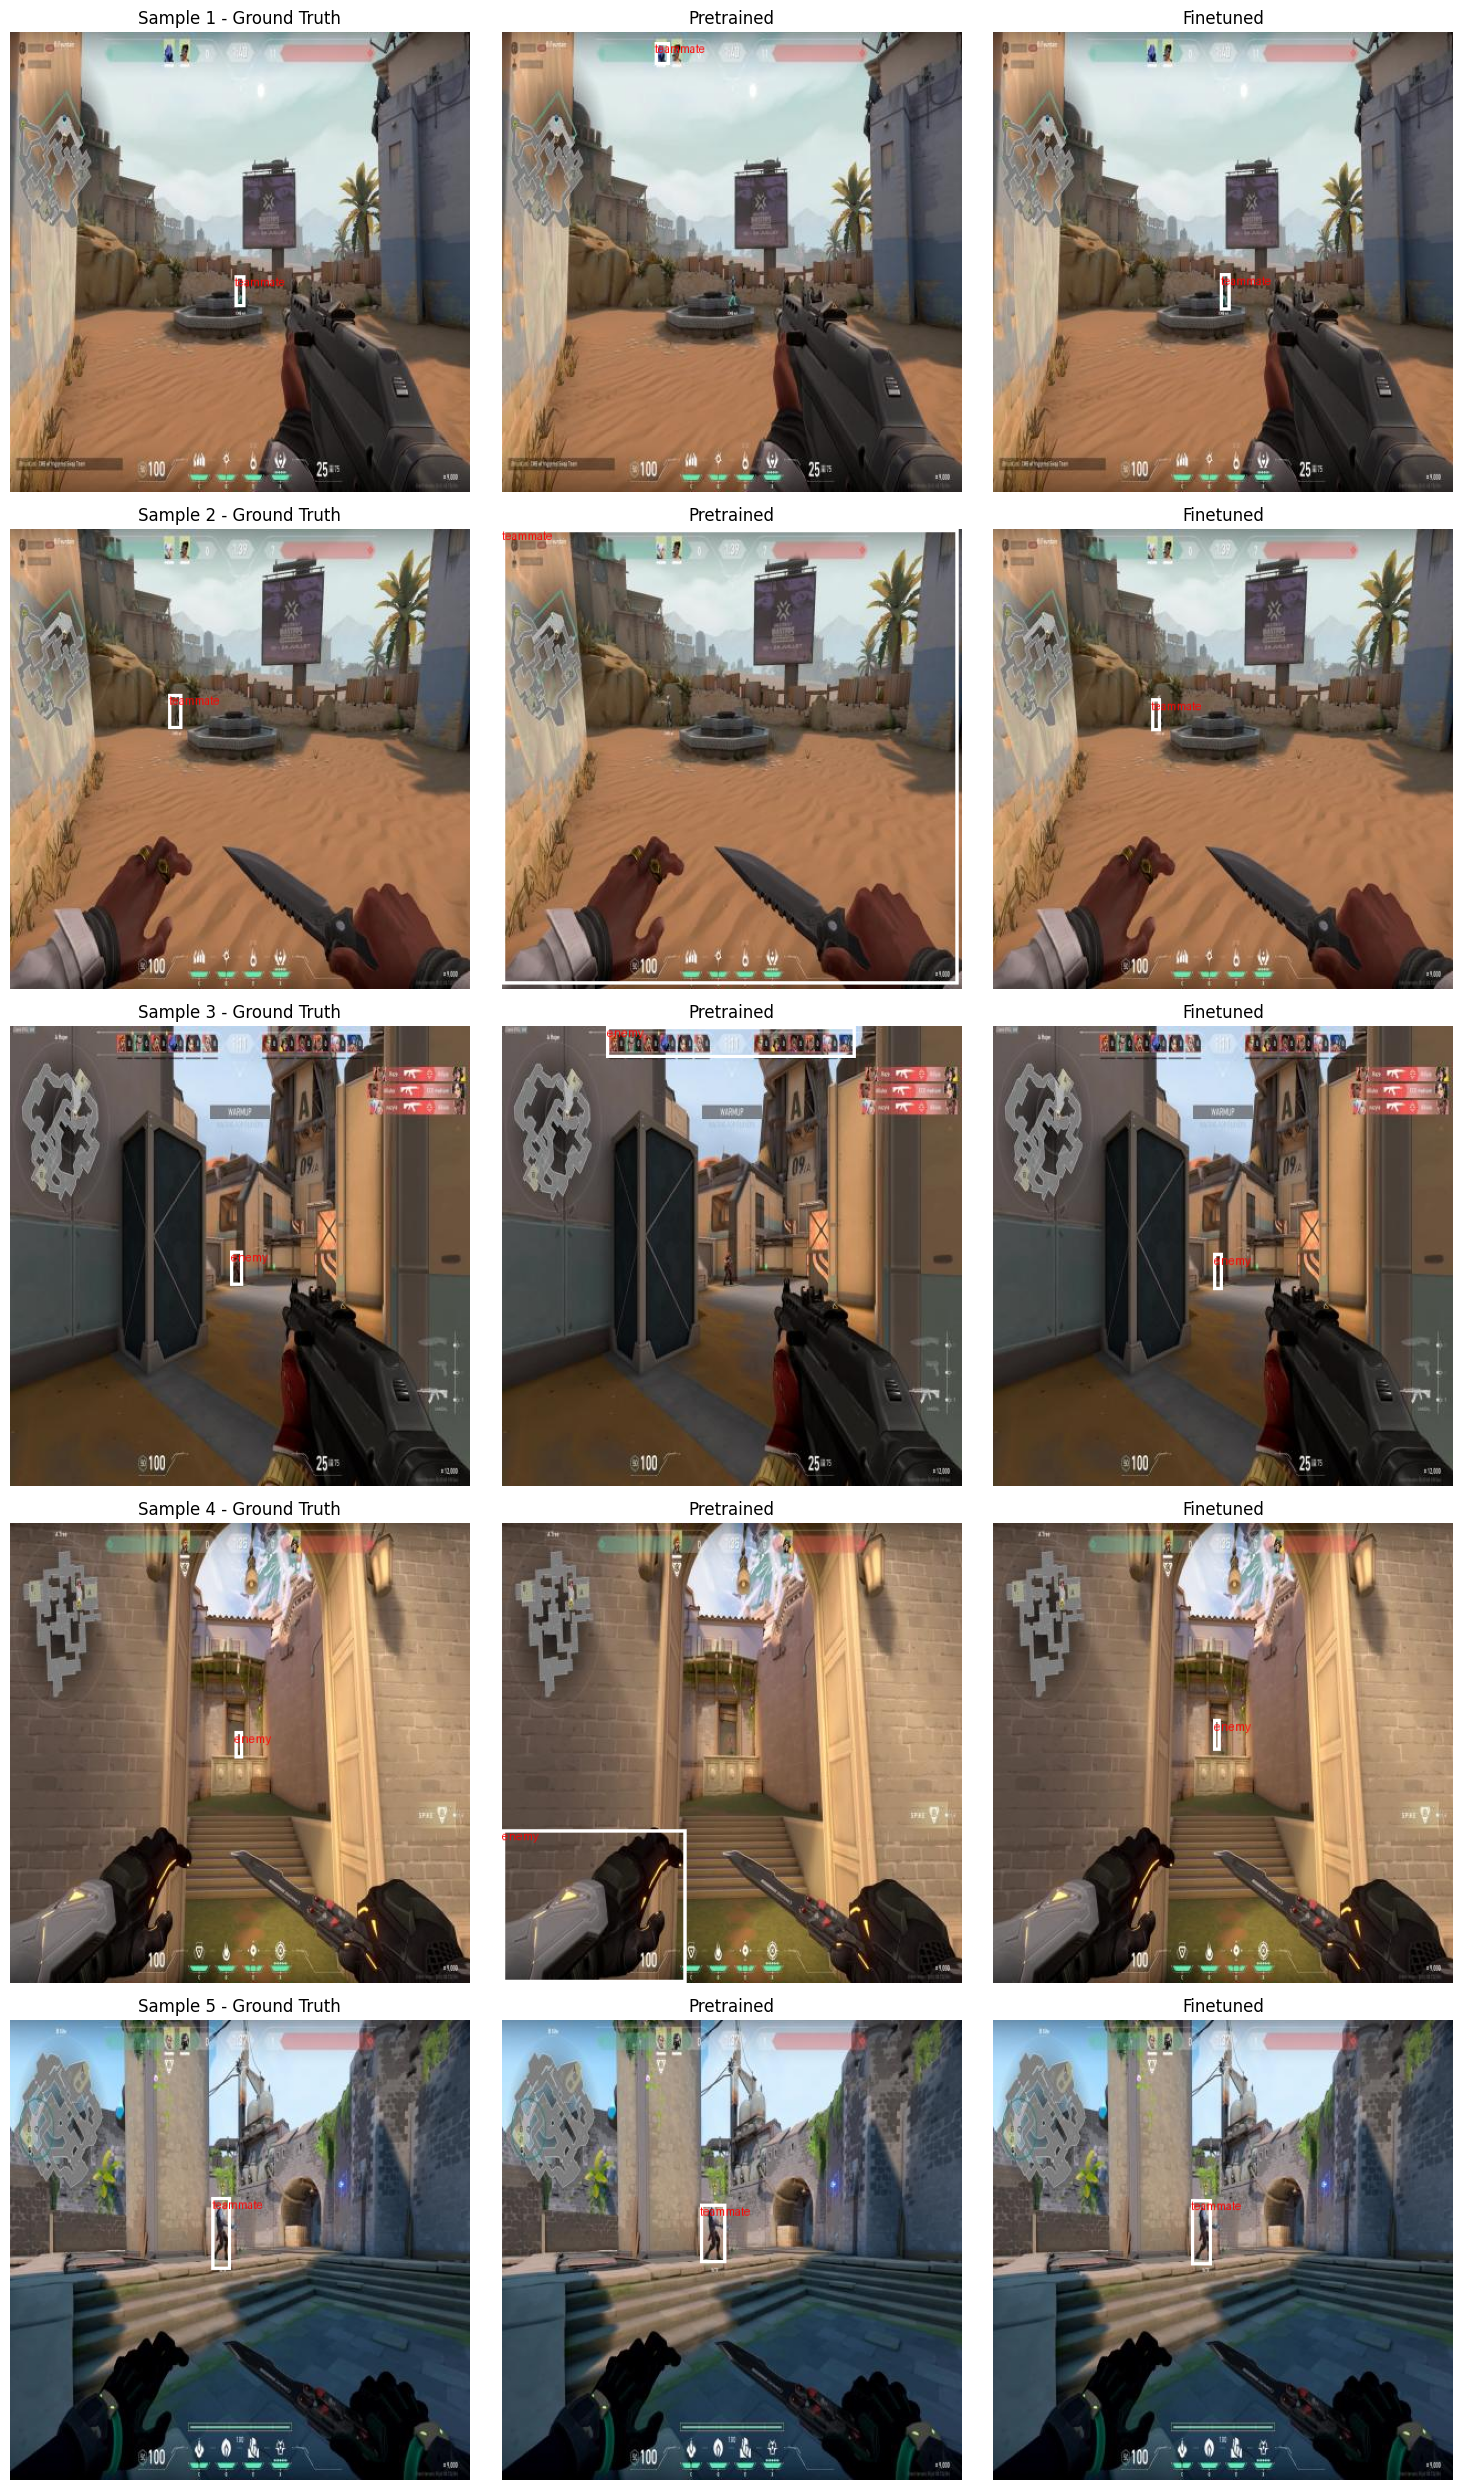

[11:43:38] [INFO] visualize_model_comparisons() took 4.61 seconds


In [ ]:
samples = test_split.select(range(5))
visualize_model_comparisons(samples, pretrained_model=pretrained_model, finetuned_model=finetuned_model)

In [ ]:
from supervision.metrics import MeanAveragePrecision, MetricTarget

map_metric = MeanAveragePrecision(metric_target=MetricTarget.BOXES)

In [ ]:
@log_time
def process_bulk_inference_with_checkpoints(model, test_dataset, model_type, batch_size=10):
    model_preds = []
    model_targets = []

    dataset_len = len(test_dataset)

    for i in range(0, dataset_len, batch_size):
        from_idx = i
        to_idx = min(i + batch_size, dataset_len)
        logger.info(f"start bulk inference from {from_idx} to {to_idx}")

        samples = test_dataset.select(range(from_idx, to_idx))

        # --- Predictions ---
        _, predictions = bulk_inference(model, samples, model_type)
        model_preds += predictions

        # --- Targets ---
        for sample in samples:
            h, w = sample["height"], sample["width"]
            encoded_gt = sample["paligemma_label"]   # <-- adjust key if needed

            # Decode GT into Detections
            target = sv.Detections.from_vlm(
                vlm="paligemma",
                result=encoded_gt,
                resolution_wh=(w, h),
                classes=classes
            )

            # Normalize class IDs (map class_name → index in classes)
            target.class_id = np.array(
                [classes.index(class_name) for class_name in target.data["class_name"]]
            )

            model_targets.append(target)

    # --- Metrics ---
    map_result = map_metric.update(model_preds, model_targets).compute()

    print(f"final mAP: {map_result}")


In [ ]:
wandb.init(project="valorant_paligemma2_benchmark", name="finetuned_run")

In [ ]:
process_bulk_inference_with_checkpoints(finetuned_model, test_split, "finetuned")

[11:45:20] [INFO] start bulk inference from 0 to 10
[11:45:21] [INFO] process_image_text() took 0.35 seconds
[11:45:21] [INFO] process_image_text() took 0.33 seconds
[11:45:21] [INFO] process_image_text() took 0.32 seconds
[11:45:22] [INFO] process_image_text() took 0.32 seconds
[11:45:22] [INFO] process_image_text() took 0.34 seconds
[11:45:22] [INFO] process_image_text() took 0.32 seconds
[11:45:23] [INFO] process_image_text() took 0.32 seconds
[11:45:23] [INFO] process_image_text() took 0.34 seconds
[11:45:23] [INFO] process_image_text() took 0.32 seconds
[11:45:24] [INFO] process_image_text() took 0.32 seconds
[11:45:24] [INFO] bulk_inference() took 3.31 seconds
[11:45:24] [INFO] start bulk inference from 10 to 20
[11:45:24] [INFO] process_image_text() took 0.33 seconds
[11:45:24] [INFO] process_image_text() took 0.32 seconds
[11:45:25] [INFO] process_image_text() took 0.32 seconds
[11:45:25] [INFO] process_image_text() took 0.32 seconds
[11:45:25] [INFO] process_image_text() took 

Error occured during model inference
No bounding box detected by model


[11:47:18] [INFO] process_image_text() took 0.32 seconds
[11:47:18] [INFO] process_image_text() took 0.32 seconds
[11:47:18] [INFO] process_image_text() took 0.32 seconds
[11:47:18] [INFO] process_image_text() took 0.32 seconds
[11:47:19] [INFO] process_image_text() took 0.32 seconds
[11:47:19] [INFO] process_image_text() took 0.32 seconds
[11:47:19] [INFO] process_image_text() took 0.32 seconds
[11:47:20] [INFO] process_image_text() took 0.32 seconds
[11:47:20] [INFO] bulk_inference() took 3.02 seconds
[11:47:20] [INFO] start bulk inference from 350 to 360
[11:47:20] [INFO] process_image_text() took 0.32 seconds
[11:47:20] [INFO] process_image_text() took 0.32 seconds
[11:47:21] [INFO] process_image_text() took 0.32 seconds
[11:47:21] [INFO] process_image_text() took 0.32 seconds
[11:47:22] [INFO] process_image_text() took 0.63 seconds
[11:47:22] [INFO] process_image_text() took 0.65 seconds
[11:47:23] [INFO] process_image_text() took 0.32 seconds
[11:47:23] [INFO] process_image_text(

final mAP: Average Precision (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.134
Average Precision (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.342
Average Precision (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.082
Average Precision (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.084
Average Precision (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ]                 = 0.372
Average Precision (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ]                 = 0.359


In [ ]:
wandb.finish()

In [ ]:
wandb.init(project="valorant_paligemma2_benchmark", name="pretrained_run")

In [ ]:
process_bulk_inference_with_checkpoints(pretrained_model, test_split, "pretrained")

[11:52:09] [INFO] start bulk inference from 0 to 10
[11:52:09] [INFO] process_image_text() took 0.26 seconds
[11:52:09] [INFO] process_image_text() took 0.23 seconds
[11:52:09] [INFO] process_image_text() took 0.23 seconds
[11:52:10] [INFO] process_image_text() took 0.23 seconds
[11:52:10] [INFO] process_image_text() took 0.23 seconds
[11:52:10] [INFO] process_image_text() took 0.23 seconds
[11:52:10] [INFO] process_image_text() took 0.23 seconds
[11:52:11] [INFO] process_image_text() took 0.23 seconds
[11:52:11] [INFO] process_image_text() took 0.23 seconds
[11:52:11] [INFO] process_image_text() took 0.23 seconds
[11:52:11] [INFO] bulk_inference() took 2.36 seconds
[11:52:11] [INFO] start bulk inference from 10 to 20
[11:52:11] [INFO] process_image_text() took 0.24 seconds
[11:52:12] [INFO] process_image_text() took 0.23 seconds
[11:52:12] [INFO] process_image_text() took 0.23 seconds
[11:52:12] [INFO] process_image_text() took 0.24 seconds
[11:52:12] [INFO] process_image_text() took 

Error occured during model inference
No bounding box detected by model


[11:53:31] [INFO] process_image_text() took 0.23 seconds
[11:53:31] [INFO] process_image_text() took 0.23 seconds
[11:53:31] [INFO] process_image_text() took 0.23 seconds
[11:53:32] [INFO] process_image_text() took 0.23 seconds
[11:53:32] [INFO] process_image_text() took 0.23 seconds
[11:53:32] [INFO] process_image_text() took 0.24 seconds
[11:53:32] [INFO] process_image_text() took 0.23 seconds
[11:53:32] [INFO] process_image_text() took 0.23 seconds
[11:53:32] [INFO] bulk_inference() took 2.22 seconds
[11:53:33] [INFO] start bulk inference from 350 to 360
[11:53:33] [INFO] process_image_text() took 0.23 seconds
[11:53:33] [INFO] process_image_text() took 0.24 seconds
[11:53:33] [INFO] process_image_text() took 0.23 seconds
[11:53:33] [INFO] process_image_text() took 0.23 seconds
[11:53:34] [INFO] process_image_text() took 0.30 seconds
[11:53:34] [INFO] process_image_text() took 0.30 seconds
[11:53:34] [INFO] process_image_text() took 0.23 seconds
[11:53:35] [INFO] process_image_text(

Error occured during model inference
No bounding box detected by model


[11:53:36] [INFO] process_image_text() took 0.24 seconds
[11:53:36] [INFO] process_image_text() took 0.23 seconds
[11:53:36] [INFO] process_image_text() took 0.23 seconds
[11:53:37] [INFO] process_image_text() took 0.23 seconds
[11:53:37] [INFO] process_image_text() took 0.23 seconds
[11:53:37] [INFO] process_image_text() took 0.23 seconds
[11:53:37] [INFO] bulk_inference() took 2.22 seconds
[11:53:37] [INFO] start bulk inference from 370 to 380
[11:53:37] [INFO] process_image_text() took 0.23 seconds
[11:53:38] [INFO] process_image_text() took 0.25 seconds
[11:53:38] [INFO] process_image_text() took 0.23 seconds
[11:53:38] [INFO] process_image_text() took 0.23 seconds
[11:53:38] [INFO] process_image_text() took 0.23 seconds
[11:53:39] [INFO] process_image_text() took 0.23 seconds
[11:53:39] [INFO] process_image_text() took 0.30 seconds
[11:53:39] [INFO] process_image_text() took 0.23 seconds
[11:53:39] [INFO] process_image_text() took 0.23 seconds
[11:53:40] [INFO] process_image_text(

Error occured during model inference
No bounding box detected by model


[11:55:39] [INFO] process_image_text() took 0.30 seconds
[11:55:40] [INFO] process_image_text() took 0.23 seconds
[11:55:40] [INFO] bulk_inference() took 2.32 seconds
[11:55:40] [INFO] start bulk inference from 880 to 890
[11:55:40] [INFO] process_image_text() took 0.23 seconds
[11:55:40] [INFO] process_image_text() took 0.25 seconds
[11:55:40] [INFO] process_image_text() took 0.23 seconds
[11:55:41] [INFO] process_image_text() took 0.23 seconds
[11:55:41] [INFO] process_image_text() took 0.23 seconds
[11:55:41] [INFO] process_image_text() took 0.23 seconds
[11:55:41] [INFO] process_image_text() took 0.23 seconds
[11:55:41] [INFO] process_image_text() took 0.23 seconds
[11:55:42] [INFO] process_image_text() took 0.23 seconds
[11:55:42] [INFO] process_image_text() took 0.24 seconds
[11:55:42] [INFO] bulk_inference() took 2.35 seconds
[11:55:42] [INFO] start bulk inference from 890 to 900
[11:55:42] [INFO] process_image_text() took 0.23 seconds
[11:55:42] [INFO] process_image_text() took

final mAP: Average Precision (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.083
Average Precision (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.211
Average Precision (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.050
Average Precision (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.048
Average Precision (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ]                 = 0.245
Average Precision (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ]                 = 0.262


In [ ]:
wandb.finish()